Script Description
This script loads a pre-processed dataset, prepares features and target variables for an embedded feature importance test.

File Name: 02_03_Feature_Selec_Embedded.ipynb

Date: 2025

Created by: Rob Alamgir

Version: 1.0

References:

#### Import the relevant packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.exceptions import FitFailedWarning
from xgboost.sklearn import XGBRegressor

#### Step 1: Load Data & prep the dataset 

In [2]:
# Load and preprocess data
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locations_Updated_6.csv"
Complete_Data = pd.read_csv(data_path)

# Data preprocessing
Complete_Data['Date'] = pd.to_datetime(Complete_Data['Date'], format='%Y-%m-%d')
Complete_Data['Source_ID'] = Complete_Data['Source'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {Complete_Data.shape}")

# Filter and clean data
filtered_df = Complete_Data.dropna(subset=['SWCT_1_015']).copy()
filtered_df['BOFEK_2020_Physical Units'] = filtered_df['BOFEK_2020_Physical Units'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

# Feature and target selection
RS_GSD_Features = ['S1_Backscatter', 'S2_NDVI', 'S2_EVI', 'S2_NDMI',
                   'L8_9_LST', 'MODIS_LAI',                                           
                   'STMP_1_015', 'ATMP_f','PAIR_f','WTMP_f','WLEV_f','WIND_f', 
                   'WINS_f','RHUM_f','RAIN_f', 'VPD_f', 'PET','ET0',
                   'NEE_CO2_kg_day_ha_DAv_NT', 'NEE_CH4_kg_day_ha_DAv_NT',
                   'Available_soil_storage_mm', 'SOM_2023_0_5_values',
                   'BD_0_5_values','Clay_0_5_values', 'Peat_Thickness_2022',
                   'BOFEK_2020_Physical Units']                
                                  
X = filtered_df[RS_GSD_Features]    # Features   
y = filtered_df['SWCT_1_015']       # Predictor
groups = filtered_df["Source_ID"]   # Groups for Leave-One-Group-Out
dates = filtered_df['Date']
print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}")

Rows and columns before removing NaNs: (36222, 109)
Rows and columns after removing NaNs: (8576, 109)
Features (X): (8576, 26), Target (y): (8576,), Groups: (8576,)


#### Step 2: Compute Feature Importance embedded in XGBoost Regression

In [3]:
# Function to calculate feature importance
def xgboost_fi(X, y):
    model = XGBRegressor(n_estimators=1000,
                         max_depth=6,
                         learning_rate=0.2,
                         subsample=0.7,
                         colsample_bytree = 0.6,
                         scale_pos_weight = 1,
                         enable_categorical=True)
    model.fit(X, y)
    feat_imps = dict(zip(X.columns, model.feature_importances_))  # Feature importances embedded in the model
    return {k: v for k, v in sorted(feat_imps.items(), key=lambda item: item[1], reverse=True)} # Return sorted feature importances

feature_importances = xgboost_fi(X, y)
print("Feature Importances:")
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Feature Importances:
WLEV_f: 0.19801385700702667
Peat_Thickness_2022: 0.11796516180038452
STMP_1_015: 0.1142568588256836
SOM_2023_0_5_values: 0.09658324718475342
ATMP_f: 0.0782935619354248
WTMP_f: 0.07163911312818527
BOFEK_2020_Physical Units: 0.0640036016702652
BD_0_5_values: 0.047291528433561325
Clay_0_5_values: 0.04453606531023979
NEE_CH4_kg_day_ha_DAv_NT: 0.023685213178396225
Available_soil_storage_mm: 0.018927497789263725
RAIN_f: 0.01427608635276556
ET0: 0.014018338173627853
VPD_f: 0.013237690553069115
PET: 0.012388728559017181
RHUM_f: 0.012068758718669415
PAIR_f: 0.008786293677985668
WIND_f: 0.00850831437855959
L8_9_LST: 0.0068534729070961475
S2_EVI: 0.006399331148713827
S2_NDVI: 0.00572216184809804
S1_Backscatter: 0.005479289218783379
NEE_CO2_kg_day_ha_DAv_NT: 0.0051157521083951
WINS_f: 0.004451522137969732
S2_NDMI: 0.004263424314558506
MODIS_LAI: 0.0032351315021514893


#### Step 3: Prep results for plotting

In [4]:
# Convert the feature importances to a DataFrame
results = pd.DataFrame({'Features': list(feature_importances.keys()),
                        'Importance': list(feature_importances.values())})

categories = {"Remotely Sensed Data": ["S1_VSM", "S1_Backscatter", "Planet_SWC", "Available_soil_storage_mm",
                                       "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI"],
              "Ground Sensed Data": ["SWCT_1_015", "STMP_1_015", "WTMP_f", "WLEV_f", "ATMP_f", "PAIR_f", 
                                     "VPD_f", "WIND_f", "WINS_f", "RAIN_f", "RHUM_f", "NDVI_f", "PET", "ET0",
                                     "NEE_CO2_kg_day_ha_DAv_NT","NEE_CH4_kg_day_ha_DAv_NT"],
              "Hybrid Sensed Data": ["Available_soil_storage_mm", "SOM_2023_0_5_values", "BD_0_5_values", "Clay_0_5_values", 
                                     "Peat_Thickness_2022", "BOFEK_2020_Physical Units"]}

feature_categories = {"Hydrological Data": ["S1_VSM", "S1_Backscatter", "Planet_SWC", "Available_soil_storage_mm", 
                                            "WTMP_f", "WLEV_f", "S2_NDMI"],
                      "Vegetative Index": ["S2_NDVI", "NDVI_f", "S2_EVI", "S2_NDMI", "MODIS_LAI"],
                      "Meteorological Data": ["L8_9_LST", "ATMP_f", "PAIR_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f",
                                              "VPD_f", "PET", "ET0", "NEE_CO2_kg_day_ha_DAv_NT",
                                              "NEE_CH4_kg_day_ha_DAv_NT"],
                      "Soil Data": ["STMP_1_015", "SOM_2023_0_5_values", "BD_0_5_values","Clay_0_5_values",
                                    "BOFEK_2020_Physical Units", "Peat_Thickness_2022"]}

# Create a function to assign categories
def assign_categories(feature, category_dict):
    assigned_categories = [category for category, features in category_dict.items() if feature in features]
    return ", ".join(assigned_categories) if assigned_categories else "Uncategorized"

# Add category columns to the DataFrame
results['Categories'] = results['Features'].apply(lambda x: assign_categories(x, categories))
results['Feature Categories'] = results['Features'].apply(lambda x: assign_categories(x, feature_categories))

#print(results) # Display the updated DataFrame

##### Plot Feature Importances Categorized by Data Sources

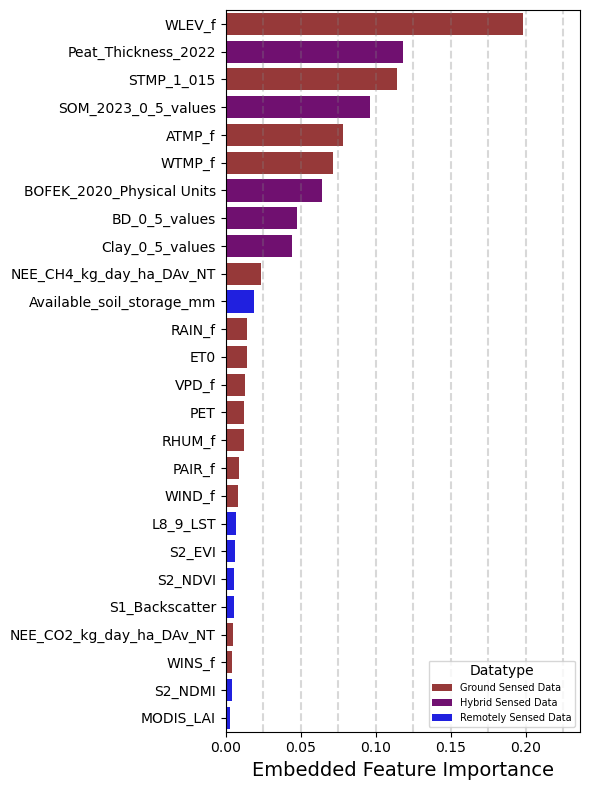

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Emb_Feat_Selec_Plot_1.png


In [12]:
# Define a color palette for the categories
category_colors = {
    "Remotely Sensed Data": "blue",
    "Ground Sensed Data": "brown",
    "Hybrid Sensed Data": "purple",
    "Hydrological Data": "blue",
    "Vegetative Index": "green",
    "Meteorological Data": "purple",
    "Soil Data": "brown"}

category_colors["Uncategorized"] = "gray"     # Add a default color for 'Uncategorized'

# Map categories to the hue variable for coloring
results['Hue'] = results['Categories'].apply(lambda x: x.split(", ")[0] if isinstance(x, str) else "Uncategorized")

# Sort the DataFrame by importance for better visualization
results = results.sort_values(by='Importance', ascending=False)

# Plot with 'Hue' as the color differentiator
plt.figure(figsize=(6, 8))
ax1 = sns.barplot(data=results, x='Importance', y='Features',
                  hue='Hue',           # Assign hue to differentiate colors
                  dodge=False,         # Prevent dodging, as we're not comparing groups within each feature
                  palette=category_colors,
                  width=0.8)

xticks = plt.xticks()[0]  # Add vertical dotted lines at each x-axis tick
for tick in xticks:
    plt.axvline(x=tick, linestyle="--", color="gray", alpha=0.3)
    
plt.xlabel("Embedded Feature Importance", fontsize=14)
plt.ylabel("", fontsize=14)
#plt.title("Feature Importances Categorized by Data Sources", fontsize=16)
plt.legend(title="Datatype", loc='lower right', fontsize=7)
plt.tight_layout()
plt.show()

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Emb_Feat_Selec_Plot_1.png"  
#ax1.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")

##### Plot Feature Importances Categorized by Data Types

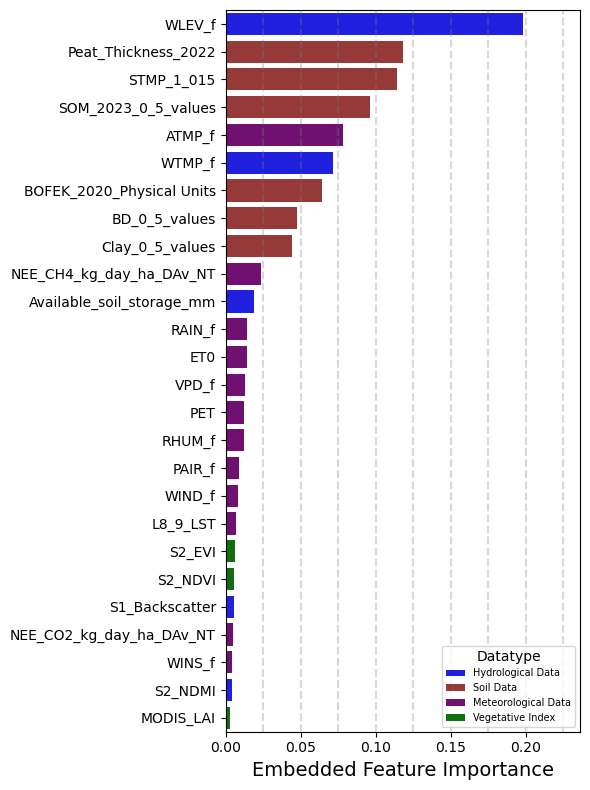

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Emb_Feat_Selec_Plot_2.png


In [14]:
# Map categories to the hue variable for coloring
results['Hue'] = results['Feature Categories'].apply(lambda x: x.split(", ")[0] if isinstance(x, str) else "Uncategorized")

# Plot with 'Hue' as the color differentiator
plt.figure(figsize=(6, 8))
ax2 = sns.barplot(data=results, x='Importance', y='Features',
            hue='Hue',                          # Assign hue to differentiate colors
            dodge=False,                        # Prevent dodging, as we're not comparing groups within each feature
            palette=category_colors,
            width=0.8)

# Add vertical dotted lines at each x-axis tick
xticks = plt.xticks()[0]  # Get the x-axis tick positions
for tick in xticks:
    plt.axvline(x=tick, linestyle="--", color="gray", alpha=0.3)
    
plt.xlabel("Embedded Feature Importance", fontsize=14)
plt.ylabel("", fontsize=14)
#plt.title("Feature Importances Categorized by Data Types", fontsize=16)
plt.legend(title="Datatype", loc='lower right', fontsize=7)
plt.tight_layout()
plt.show()

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Emb_Feat_Selec_Plot_2.png"  
#ax2.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")